In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Liar Dataset

In [ ]:
# Load data
liar_df = pd.read_csv('Liar_Dataset.csv')

In [ ]:
# Function to clean statment
def clean_text(text):
    """
    Clean and normalize text data
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

#Function to tokenize
def preprocess_text(text):
    """
    Tokenize and remove stopwords
    """
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

## Cleaning & Preprocessing

In [ ]:
# Apply cleaning
liar_df['statement_clean'] = liar_df['statement'].apply(clean_text)

# Apply preprocessing
liar_df['statement_processed'] = liar_df['statement_clean'].apply(preprocess_text)

# Apply encoding
label_encoder = LabelEncoder()
liar_df['label_encoded'] = label_encoder.fit_transform(liar_df['label'])

### Handling Null Values


In [ ]:
# Handle missing values
liar_df["speaker's job title"].fillna("Unknown", inplace=True)
liar_df["state info"].fillna("Unknown", inplace=True)
liar_df["venue"].fillna("Unknown", inplace=True)

/tmp/ipython-input-3756403148.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  liar_df["speaker's job title"].fillna("Unknown", inplace=True)
/tmp/ipython-input-3756403148.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [ ]:
liar_df.isnull().sum()

,0
[ID].json,0
label,0
statement,0
subject(s),0
speaker,0
speaker's job title,0
state info,0
party affiliation,0
barely true counts,0
false counts,0


### Encoding Metadata

In [ ]:
# Encode categorical metadata
speaker_encoder = LabelEncoder()
subject_encoder = LabelEncoder()
speaker_job_title_encoder = LabelEncoder()
state_encoder = LabelEncoder()
party_encoder = LabelEncoder()
venue_encoder = LabelEncoder()

liar_df['speaker_encoded'] = speaker_encoder.fit_transform(liar_df['speaker'])
liar_df['subject_encoded'] = subject_encoder.fit_transform(liar_df['subject(s)'])
liar_df['speaker_job_encoded'] = speaker_job_title_encoder.fit_transform(liar_df["speaker's job title"])
liar_df['state_encoded'] = state_encoder.fit_transform(liar_df['state info'])
liar_df['party_encoded'] = party_encoder.fit_transform(liar_df['party affiliation'])
liar_df['venue_encoded'] = venue_encoder.fit_transform(liar_df['venue'])

## TF-IDF Vectorization

In [ ]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Limit to top 5000 features
    ngram_range=(1, 2),     # Unigrams and bigrams
    min_df=2,               # Ignore terms that appear in fewer than 2 documents
    max_df=0.8              # Ignore terms that appear in more than 80% of documents
)

# Fit on LIAR training data
X_text_tfidf = tfidf_vectorizer.fit_transform(liar_df['statement_processed'])

In [ ]:
from scipy.sparse import hstack

# Get metadata as array
metadata_features = liar_df[['speaker_encoded', 'subject_encoded',
                             'speaker_job_encoded', 'state_encoded', 'party_encoded',
                             'venue_encoded']].values

# Combine TF-IDF with metadata
X_combined = hstack([X_text_tfidf, metadata_features])

print(f"Text features shape: {X_text_tfidf.shape}")
print(f"Metadata features shape: {metadata_features.shape}")
print(f"Combined features shape: {X_combined.shape}")

Text features shape: (12787, 5000)
Metadata features shape: (12787, 6)
Combined features shape: (12787, 5006)


## Training & Split

In [ ]:
from sklearn.model_selection import train_test_split

# LIAR dataset
y = liar_df['label_encoded'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (8950, 5006)
Validation set: (1918, 5006)
Test set: (1919, 5006)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

### Decision Tree

Decision Tree - Validation Set Performance:
Accuracy: 0.2456

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.24      0.25       376
           1       0.20      0.05      0.07       308
           2       0.22      0.03      0.06       315
           3       0.23      0.40      0.29       394
           4       0.24      0.49      0.33       368
           5       0.46      0.13      0.21       157

    accuracy                           0.25      1918
   macro avg       0.27      0.22      0.20      1918
weighted avg       0.25      0.25      0.21      1918



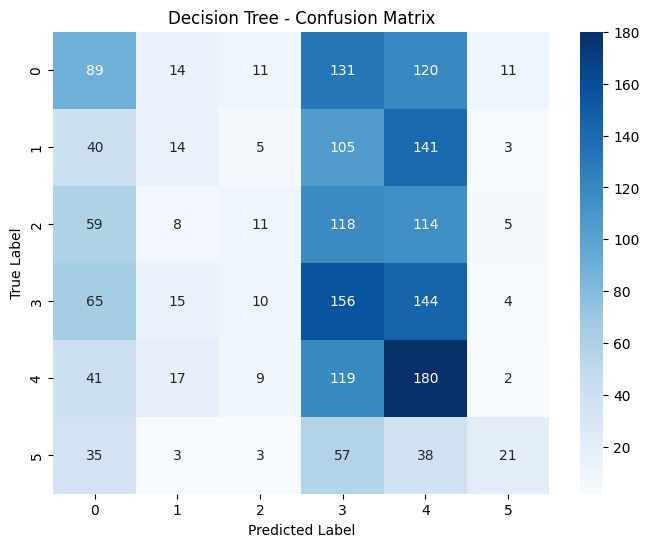

In [ ]:
# Train a simple decision tree
dt_model = DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

# Fit on training data
dt_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = dt_model.predict(X_val)

# Evaluate
print("Decision Tree - Validation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Top 20 Most Important Features:
                  feature  importance
5000              speaker    0.163146
5004    party affiliation    0.077873
5005                venue    0.058329
5002  speaker's job title    0.047103
5001           subject(s)    0.046437
5003           state info    0.031791
3091              percent    0.029094
3808                 says    0.025418
4521                today    0.024458
2156                 jobs    0.018434
3916                scott    0.018421
1374                every    0.017115
4886            wisconsin    0.015739
3274            president    0.013549
4385                taxes    0.012287
92        africanamerican    0.011436
2846            obamacare    0.011344
258              attorney    0.011325
2731               nearly    0.011122
3411                  put    0.010634


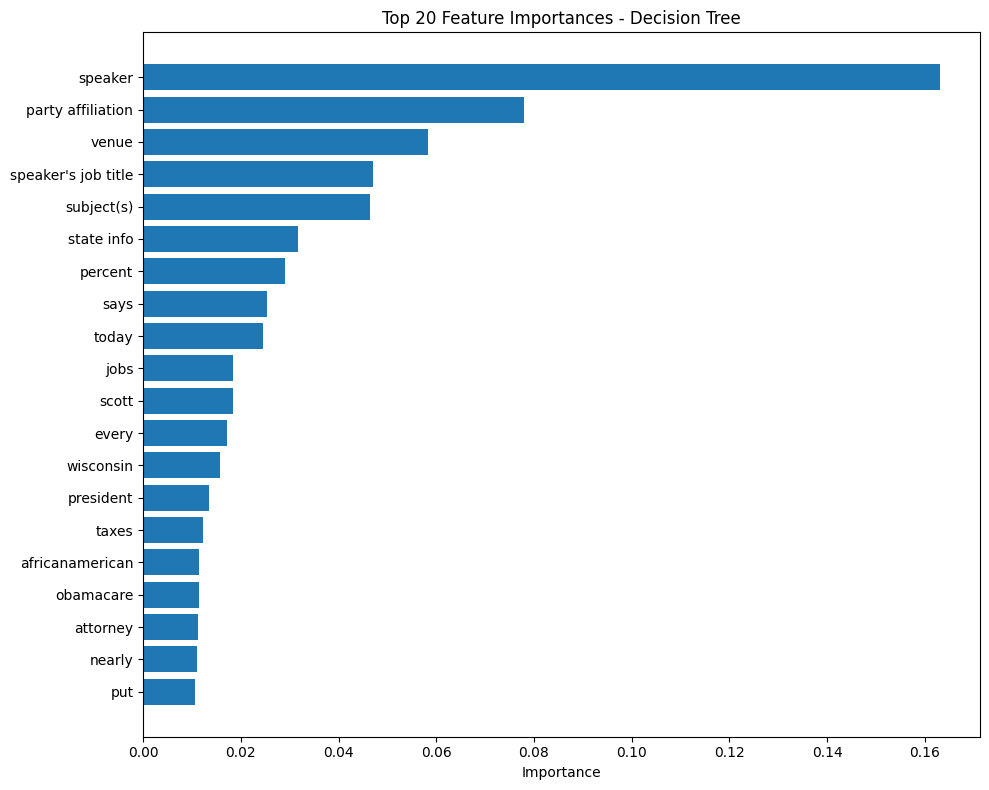

In [ ]:
# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out().tolist()
feature_names.extend(['speaker', 'subject(s)',"speaker's job title", 'state info', 'party affiliation', 'venue'])

# Get feature importances
importances = dt_model.feature_importances_

# Create DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Show top 20 most important features
print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20))

# Visualize
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(20)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Random Forest

Training Random Forest...

Random Forest - Validation Set Performance:
Accuracy: 0.2289

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.21      0.24       376
           1       0.12      0.00      0.01       308
           2       0.43      0.03      0.05       315
           3       0.21      0.72      0.32       394
           4       0.27      0.17      0.21       368
           5       1.00      0.01      0.01       157

    accuracy                           0.23      1918
   macro avg       0.38      0.19      0.14      1918
weighted avg       0.32      0.23      0.16      1918



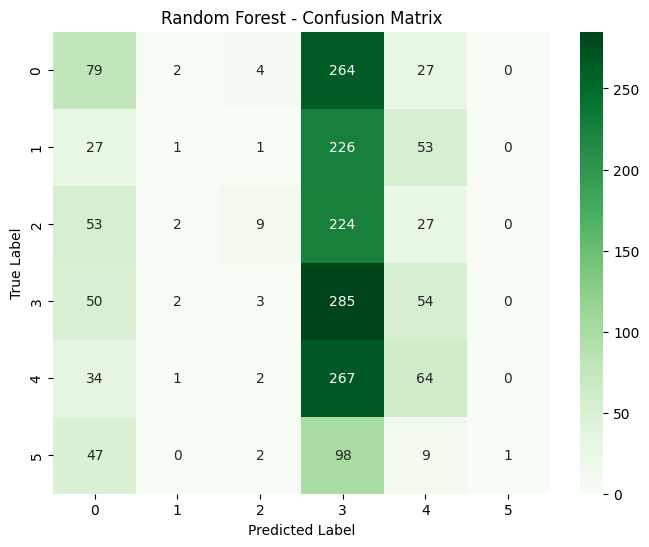

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Fit
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# Predict
y_val_pred_rf = rf_model.predict(X_val)

# Evaluate
print("\nRandom Forest - Validation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Hyperparameter Tuning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [50, 100, 200]
}

# Grid search
print("Starting Grid Search (this may take a while)...")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,                    # 3-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest Parameters:")
print(grid_search.best_params_)
print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

# Use best model
best_rf_model = grid_search.best_estimator_

# Evaluate on validation set
y_val_pred_best = best_rf_model.predict(X_val)
print(f"\nBest Model Validation Accuracy: {accuracy_score(y_val, y_val_pred_best):.4f}")

Starting Grid Search (this may take a while)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Parameters:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Best Cross-Validation Score: 0.2545

Best Model Validation Accuracy: 0.2669


In [ ]:
# Train model with TEXT ONLY (no metadata)
rf_text_only = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

# Use only TF-IDF features (not X_combined)
rf_text_only.fit(X_train[:, :5000], y_train)  # First 5000 columns are text features
y_val_pred_text = rf_text_only.predict(X_val[:, :5000])

print("Text Only Model:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_text):.4f}")

print("\nText + Metadata Model:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")

print(f"\nImprovement from adding metadata: {(accuracy_score(y_val, y_val_pred_rf) - accuracy_score(y_val, y_val_pred_text))*100:.2f}%")

Text Only Model:
Accuracy: 0.2211

Text + Metadata Model:
Accuracy: 0.2289

Improvement from adding metadata: 0.78%


## Evaluation

FINAL TEST SET PERFORMANCE
Accuracy: 0.2694

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.38      0.30       376
           1       0.29      0.15      0.20       308
           2       0.24      0.14      0.18       316
           3       0.27      0.34      0.30       394
           4       0.28      0.36      0.31       368
           5       0.63      0.11      0.18       157

    accuracy                           0.27      1919
   macro avg       0.33      0.25      0.25      1919
weighted avg       0.30      0.27      0.26      1919



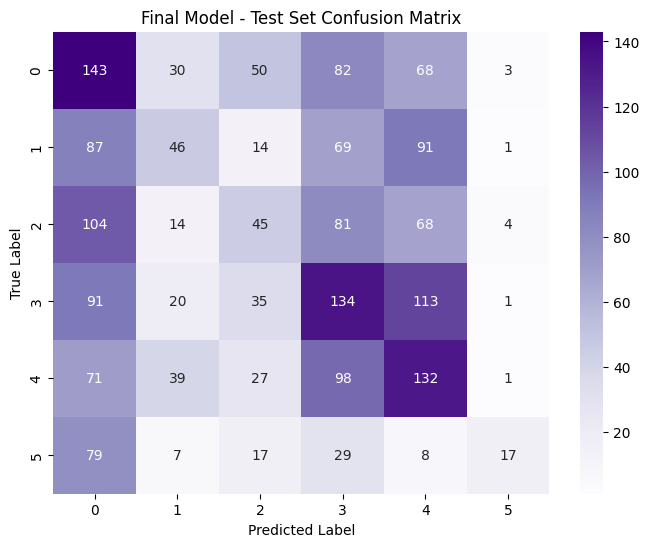

In [ ]:
final_model = best_rf_model

# Predict on test set
y_test_pred = final_model.predict(X_test)

# Final evaluation
print("=" * 50)
print("FINAL TEST SET PERFORMANCE")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Purples')
plt.title('Final Model - Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ISOT Dataset

In [ ]:
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

fake_df['label'] = 0
true_df['label'] = 1

isot_df = pd.concat([fake_df, true_df], ignore_index=True)

isot_df = isot_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"ISOT Dataset size: {len(isot_df)}")
print(f"\nLabel distribution:")
print(isot_df['label'].value_counts())
print(f"\nColumns: {isot_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(isot_df.head())

ISOT Dataset size: 44898

Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64

Columns: ['title', 'text', 'subject', 'date', 'label']

First few rows:
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1    

## Cleaning & Preprocessing

In [ ]:
def clean_text_improved(text):
    """
    Improved text cleaning that preserves more structure
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s\.\,\!\?]', ' ', text)  # Keep . , ! ?
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
isot_df['combined_text'] = isot_df['title'].fillna('') + ' ' + isot_df['text'].fillna('')
isot_df['text_clean'] = isot_df['combined_text'].apply(clean_text_improved)
isot_df['text_processed'] = isot_df['text_clean'].apply(preprocess_text)

print(isot_df['text_processed'].iloc[0][:500])

ben stein calls th circuit court committed coup tat constitution st century wire says ben stein , reputable professor , pepperdine university also hollywood fame appearing tv shows films ferris bueller day made provocative statements judge jeanine pirro show recently . discussing halt imposed president trump executive order travel . stein referred judgement th circuit court washington state coup tat executive branch constitution . stein went call judges seattle political puppets judiciary politi


## TF-IDF Encoding

In [ ]:
isot_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

# Transform text
print("Creating TF-IDF features...")
X_isot = isot_vectorizer.fit_transform(isot_df['text_processed'])
y_isot = isot_df['label'].values

print(f"\nISOT Feature matrix shape: {X_isot.shape}")
print(f"ISOT Labels shape: {y_isot.shape}")
print(f"Label distribution: {np.bincount(y_isot)}")

Creating TF-IDF features...

ISOT Feature matrix shape: (44898, 5000)
ISOT Labels shape: (44898,)
Label distribution: [23481 21417]


## Training & Split

In [ ]:
X_isot_train, X_isot_temp, y_isot_train, y_isot_temp = train_test_split(
    X_isot,
    y_isot,
    test_size=0.3,
    random_state=42,
    stratify=y_isot
)

X_isot_val, X_isot_test, y_isot_val, y_isot_test = train_test_split(
    X_isot_temp,
    y_isot_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_isot_temp
)

print(f"ISOT Training set: {X_isot_train.shape[0]} samples ({X_isot_train.shape[0]/len(y_isot)*100:.1f}%)")
print(f"ISOT Validation set: {X_isot_val.shape[0]} samples ({X_isot_val.shape[0]/len(y_isot)*100:.1f}%)")
print(f"ISOT Test set: {X_isot_test.shape[0]} samples ({X_isot_test.shape[0]/len(y_isot)*100:.1f}%)")

ISOT Training set: 31428 samples (70.0%)
ISOT Validation set: 6735 samples (15.0%)
ISOT Test set: 6735 samples (15.0%)


### Decision Tree

Training Decision Tree on ISOT...

DECISION TREE - ISOT VALIDATION SET PERFORMANCE
Accuracy: 0.9981

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      3522
        Real       1.00      1.00      1.00      3213

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



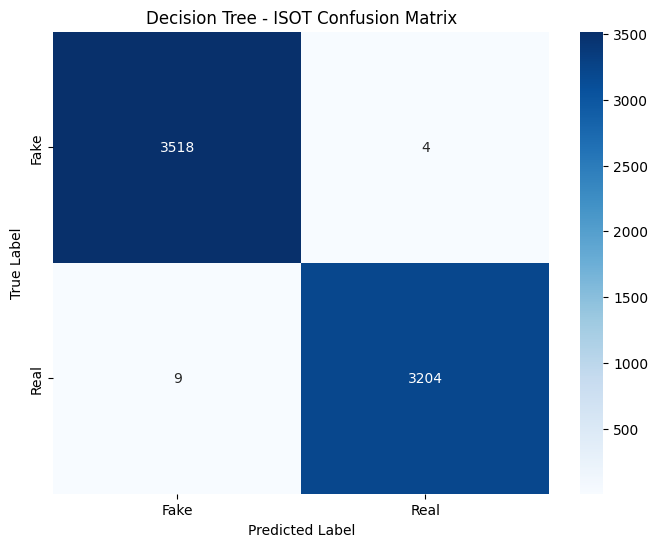

In [ ]:
print("Training Decision Tree on ISOT...")
dt_isot = DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

dt_isot.fit(X_isot_train, y_isot_train)

# Predict on validation set
y_isot_val_pred_dt = dt_isot.predict(X_isot_val)

# Evaluate
print("\n" + "="*60)
print("DECISION TREE - ISOT VALIDATION SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {accuracy_score(y_isot_val, y_isot_val_pred_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_isot_val, y_isot_val_pred_dt, target_names=['Fake', 'Real']))

# Confusion Matrix
cm_dt_isot = confusion_matrix(y_isot_val, y_isot_val_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_isot, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Decision Tree - ISOT Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


TOP 20 MOST IMPORTANT FEATURES - DECISION TREE (ISOT)
                feature  importance
3724            reuters    0.971371
4437                the    0.015928
1607     featured image    0.002542
2136                 in    0.002035
4994               zika    0.000893
4648        twitter com    0.000892
3972               sept    0.000682
593                 but    0.000638
4454               this    0.000637
3266              polls    0.000511
632   candidate hillary    0.000427
4160          spokesman    0.000348
2693           meetings    0.000334
1114            declare    0.000255
690        century wire    0.000255
1564            factbox    0.000255
1027             crimes    0.000246
4152              spend    0.000239
2388           kim jong    0.000170
2410            kushner    0.000128


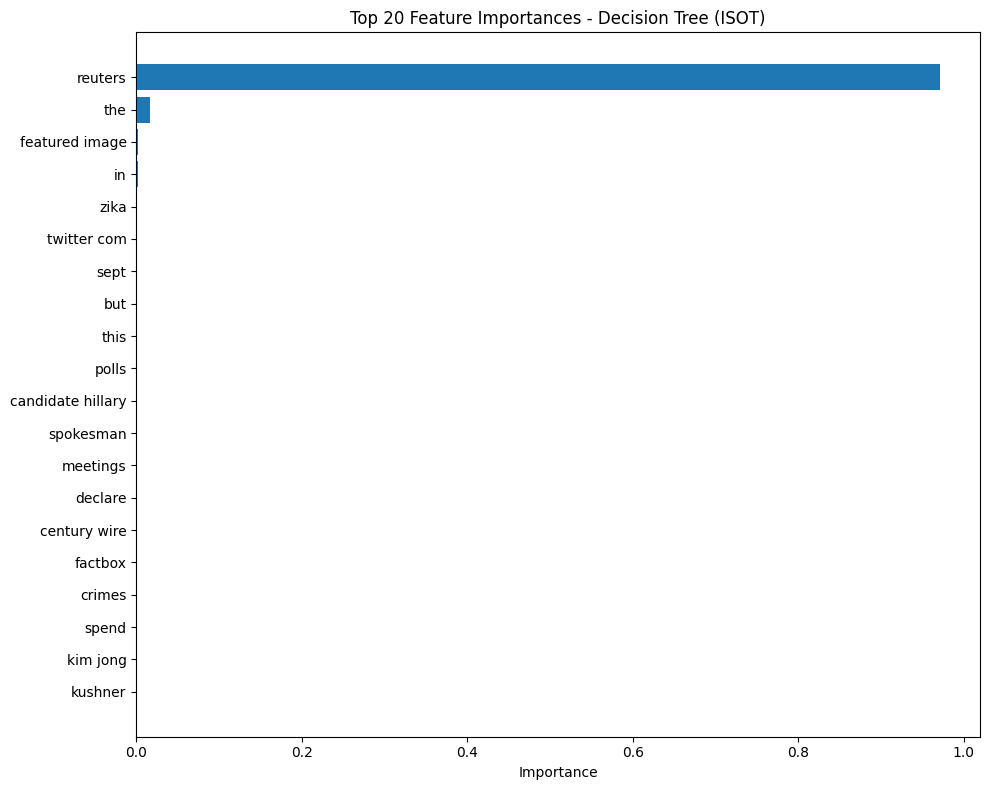

In [ ]:
# Get feature importances
feature_names_isot = isot_vectorizer.get_feature_names_out().tolist()
importances_isot = dt_isot.feature_importances_

# Create DataFrame
feature_importance_isot_df = pd.DataFrame({
    'feature': feature_names_isot,
    'importance': importances_isot
}).sort_values('importance', ascending=False)

# Top 20 features
print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES - DECISION TREE (ISOT)")
print("="*60)
print(feature_importance_isot_df.head(20))

# Visualize
plt.figure(figsize=(10, 8))
top_features_isot = feature_importance_isot_df.head(20)
plt.barh(top_features_isot['feature'], top_features_isot['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Decision Tree (ISOT)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Random Forest

Training Random Forest on ISOT...

RANDOM FOREST - ISOT VALIDATION SET PERFORMANCE
Accuracy: 0.9972

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      3522
        Real       0.99      1.00      1.00      3213

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



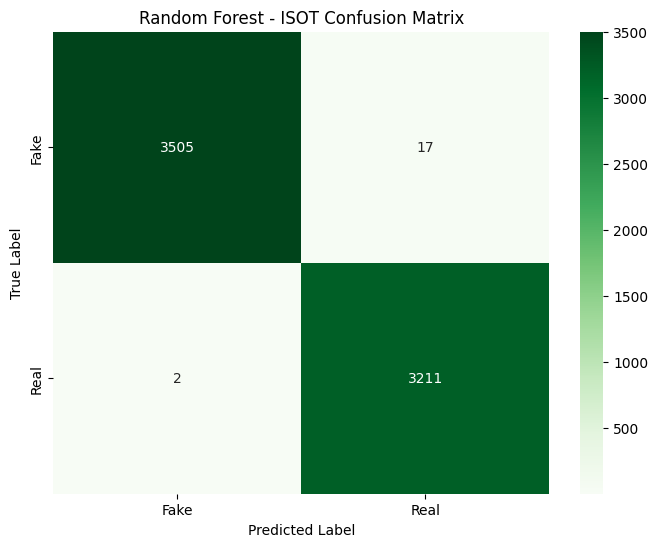

In [ ]:
# Train Random Forest
print("Training Random Forest on ISOT...")
rf_isot = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_isot.fit(X_isot_train, y_isot_train)

# Predict
y_isot_val_pred_rf = rf_isot.predict(X_isot_val)

# Evaluate
print("\n" + "="*60)
print("RANDOM FOREST - ISOT VALIDATION SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {accuracy_score(y_isot_val, y_isot_val_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_isot_val, y_isot_val_pred_rf, target_names=['Fake', 'Real']))

# Confusion Matrix
cm_rf_isot = confusion_matrix(y_isot_val, y_isot_val_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_isot, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Random Forest - ISOT Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Hyperparameter Tuning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Reduced grid for speed
param_grid_isot = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 10],
    'n_estimators': [50, 100]
}

print("Starting Grid Search for ISOT (this will take a while)...")
grid_search_isot = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_isot,
    cv=2,  # Reduced folds for speed
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search_isot.fit(X_isot_train, y_isot_train)

print("\n" + "="*60)
print("GRID SEARCH RESULTS - ISOT")
print("="*60)
print(f"Best Parameters: {grid_search_isot.best_params_}")
print(f"Best Cross-Validation Score: {grid_search_isot.best_score_:.4f}")

# Use best model
best_rf_isot = grid_search_isot.best_estimator_

# Evaluate on validation
y_isot_val_pred_best = best_rf_isot.predict(X_isot_val)
print(f"Best Model Validation Accuracy: {accuracy_score(y_isot_val, y_isot_val_pred_best):.4f}")

Starting Grid Search for ISOT (this will take a while)...
Fitting 2 folds for each of 8 candidates, totalling 16 fits

GRID SEARCH RESULTS - ISOT
Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Score: 0.9978
Best Model Validation Accuracy: 0.9981


## Evaluation


FINAL TEST SET PERFORMANCE - ISOT DATASET
Accuracy: 0.9988

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      3523
        Real       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



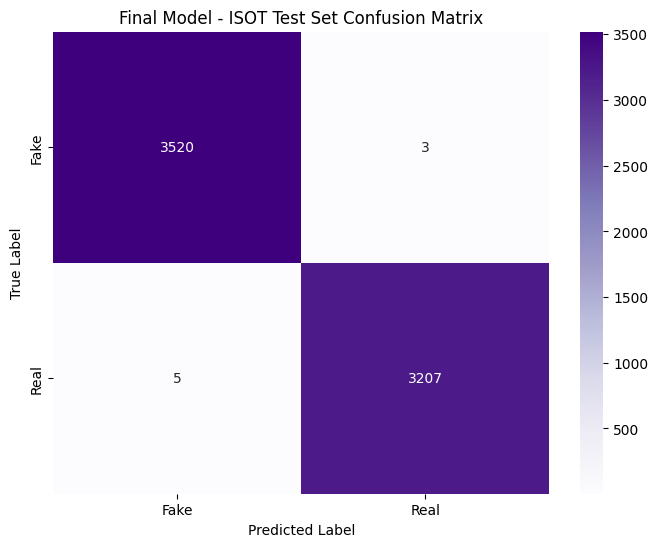

In [ ]:
final_isot_model = best_rf_isot

# Predict on test set
y_isot_test_pred = final_isot_model.predict(X_isot_test)

print("\n" + "="*70)
print("FINAL TEST SET PERFORMANCE - ISOT DATASET")
print("="*70)
print(f"Accuracy: {accuracy_score(y_isot_test, y_isot_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_isot_test, y_isot_test_pred, target_names=['Fake', 'Real']))

# Final Confusion Matrix
cm_test_isot = confusion_matrix(y_isot_test, y_isot_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_isot, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Final Model - ISOT Test Set Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print("\n" + "="*80)
print("MODEL COMPARISON: LIAR vs ISOT")
print("="*80)

# LIAR Results
print("\nLIAR DATASET (6-class):")
print(f"Decision Tree Validation Accuracy: 0.245")
print(f"Random Forest Validation Accuracy: 0.27")

# ISOT Results
print("\nISOT DATASET (Binary):")
print(f"Decision Tree Validation Accuracy: {accuracy_score(y_isot_val, y_isot_val_pred_dt):.4f}")
print(f"Random Forest Validation Accuracy: {accuracy_score(y_isot_test, y_isot_test_pred):.4f}")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("1. ISOT (binary) is easier than LIAR (6-class)")
print("2. Both datasets show Random Forest performs similarly to Decision Tree")
print("3. Models generalize to different text formats (short statements vs long articles)")


MODEL COMPARISON: LIAR vs ISOT

LIAR DATASET (6-class):
Decision Tree Validation Accuracy: 0.245
Random Forest Validation Accuracy: 0.27

ISOT DATASET (Binary):
Decision Tree Validation Accuracy: 0.9981
Random Forest Validation Accuracy: 0.9988

KEY INSIGHTS:
1. ISOT (binary) is easier than LIAR (6-class)
2. Both datasets show Random Forest performs similarly to Decision Tree
3. Models generalize to different text formats (short statements vs long articles)


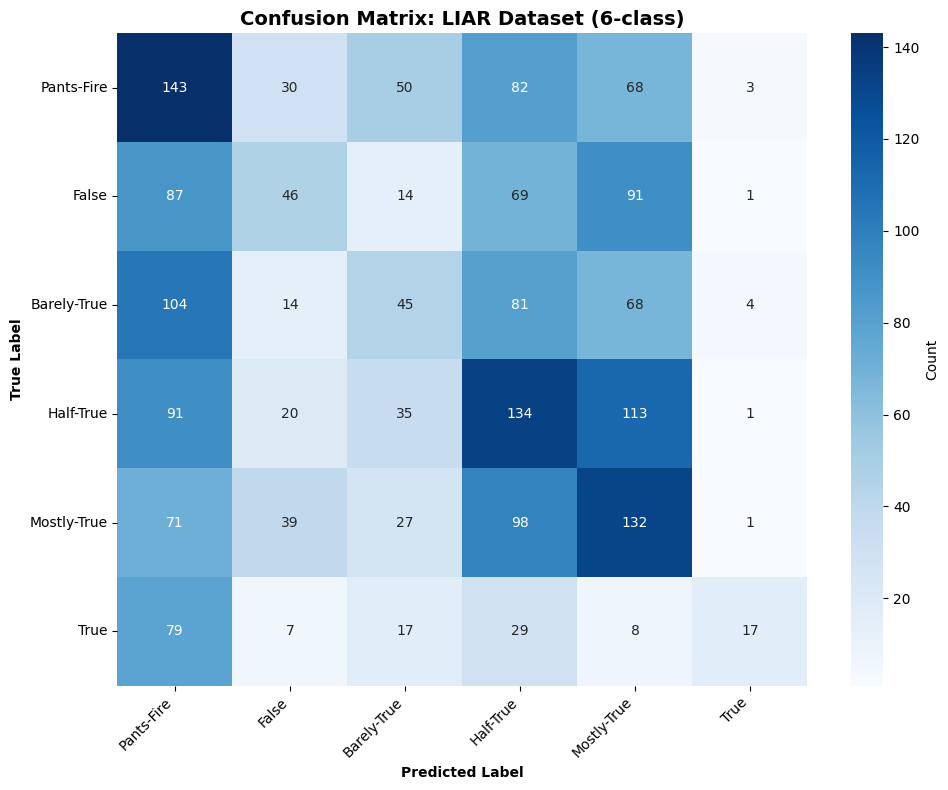

Most Common Misclassifications:
Pants-Fire misclassified as False: 30 times (8.0%)
Pants-Fire misclassified as Barely-True: 50 times (13.3%)
Pants-Fire misclassified as Half-True: 82 times (21.8%)
Pants-Fire misclassified as Mostly-True: 68 times (18.1%)
Pants-Fire misclassified as True: 3 times (0.8%)
False misclassified as Pants-Fire: 87 times (28.2%)
False misclassified as Barely-True: 14 times (4.5%)
False misclassified as Half-True: 69 times (22.4%)
False misclassified as Mostly-True: 91 times (29.5%)
False misclassified as True: 1 times (0.3%)
Barely-True misclassified as Pants-Fire: 104 times (32.9%)
Barely-True misclassified as False: 14 times (4.4%)
Barely-True misclassified as Half-True: 81 times (25.6%)
Barely-True misclassified as Mostly-True: 68 times (21.5%)
Barely-True misclassified as True: 4 times (1.3%)
Half-True misclassified as Pants-Fire: 91 times (23.1%)
Half-True misclassified as False: 20 times (5.1%)
Half-True misclassified as Barely-True: 35 times (8.9%)
Half-

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Get predictions on test set
y_test_pred = best_rf_model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
labels = ['Pants-Fire', 'False', 'Barely-True', 'Half-True', 'Mostly-True', 'True']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix: LIAR Dataset (6-class)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_liar.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze which classes are most confused
print("Most Common Misclassifications:")
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and cm[i, j] > 0:
            print(f"{labels[i]} misclassified as {labels[j]}: {cm[i, j]} times ({cm[i, j]/cm[i].sum()*100:.1f}%)")


Detailed Per-Class Metrics:
              precision    recall  f1-score      support
Pants-Fire     0.248696  0.380319  0.300736   376.000000
False          0.294872  0.149351  0.198276   308.000000
Barely-True    0.239362  0.142405  0.178571   316.000000
Half-True      0.271805  0.340102  0.302142   394.000000
Mostly-True    0.275000  0.358696  0.311321   368.000000
True           0.629630  0.108280  0.184783   157.000000
accuracy       0.269411  0.269411  0.269411     0.269411
macro avg      0.326561  0.246525  0.245971  1919.000000
weighted avg   0.295524  0.269411  0.257006  1919.000000


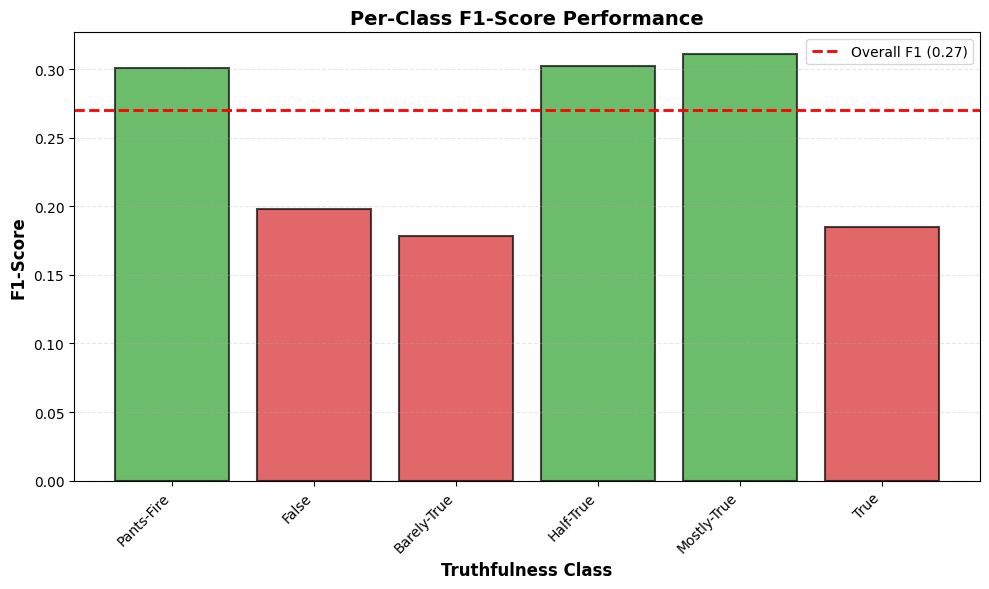


Best performing class: Mostly-True
F1-score: 0.311

Worst performing class: Barely-True
F1-score: 0.179


In [34]:
# Detailed classification report
print("\nDetailed Per-Class Metrics:")
print("="*70)
report = classification_report(y_test, y_test_pred,
                              target_names=labels,
                              output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Visualize per-class F1 scores
plt.figure(figsize=(10, 6))
class_f1 = [report[label]['f1-score'] for label in labels]
colors = ['#d62728' if f1 < 0.2 else '#ff7f0e' if f1 < 0.3 else '#2ca02c' for f1 in class_f1]

bars = plt.bar(labels, class_f1, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.axhline(y=0.27, color='red', linestyle='--', linewidth=2, label='Overall F1 (0.27)')
plt.ylabel('F1-Score', fontweight='bold', fontsize=12)
plt.xlabel('Truthfulness Class', fontweight='bold', fontsize=12)
plt.title('Per-Class F1-Score Performance', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('per_class_f1.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify best and worst performing classes
print("\nBest performing class:", labels[np.argmax(class_f1)])
print(f"F1-score: {max(class_f1):.3f}")
print("\nWorst performing class:", labels[np.argmin(class_f1)])
print(f"F1-score: {min(class_f1):.3f}")


Performance by Statement Length:
Short (<10 words):
  Samples: 189
  Accuracy: 0.296
  F1-Score: 0.283

Medium (10-20 words):
  Samples: 1023
  Accuracy: 0.273
  F1-Score: 0.257

Long (>20 words):
  Samples: 707
  Accuracy: 0.257
  F1-Score: 0.251



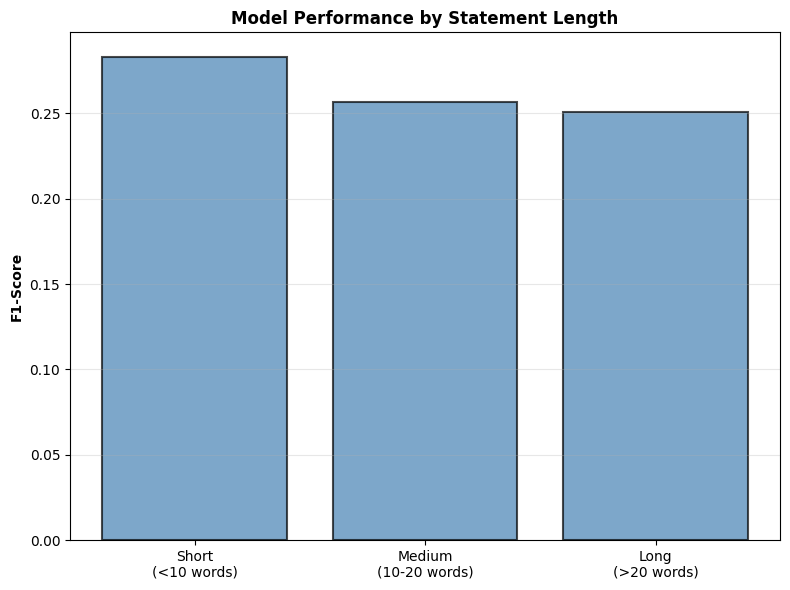

In [35]:
# Analyze performance by statement length
liar_df['statement_length'] = liar_df['statement'].str.split().str.len()

# Create length categories
def categorize_length(length):
    if length < 10:
        return 'Short (<10 words)'
    elif length < 20:
        return 'Medium (10-20 words)'
    else:
        return 'Long (>20 words)'

liar_df['length_category'] = liar_df['statement_length'].apply(categorize_length)

# Performance by length
print("\nPerformance by Statement Length:")
print("="*70)
for category in ['Short (<10 words)', 'Medium (10-20 words)', 'Long (>20 words)']:
    mask = liar_df['length_category'] == category
    if mask.sum() > 0:
        # Get indices for this category in test set
        category_indices = liar_df[mask].index
        test_category_mask = np.isin(range(len(liar_df)), category_indices)

        if test_category_mask.any():
            y_category = y_test[test_category_mask[:len(y_test)]]
            y_pred_category = y_test_pred[test_category_mask[:len(y_test)]]

            from sklearn.metrics import accuracy_score, f1_score
            acc = accuracy_score(y_category, y_pred_category)
            f1 = f1_score(y_category, y_pred_category, average='weighted')

            print(f"{category}:")
            print(f"  Samples: {len(y_category)}")
            print(f"  Accuracy: {acc:.3f}")
            print(f"  F1-Score: {f1:.3f}")
            print()

# Visualize
length_performance = []
for category in ['Short (<10 words)', 'Medium (10-20 words)', 'Long (>20 words)']:
    mask = liar_df['length_category'] == category
    if mask.sum() > 0:
        category_indices = liar_df[mask].index
        test_category_mask = np.isin(range(len(liar_df)), category_indices)

        if test_category_mask.any():
            y_category = y_test[test_category_mask[:len(y_test)]]
            y_pred_category = y_test_pred[test_category_mask[:len(y_test)]]
            f1 = f1_score(y_category, y_pred_category, average='weighted')
            length_performance.append(f1)
        else:
            length_performance.append(0)

plt.figure(figsize=(8, 6))
plt.bar(['Short\n(<10 words)', 'Medium\n(10-20 words)', 'Long\n(>20 words)'],
        length_performance, color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('F1-Score', fontweight='bold')
plt.title('Model Performance by Statement Length', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('performance_by_length.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
# Sample misclassified examples for manual analysis
misclassified_indices = np.where(y_test != y_test_pred)[0]

print(f"\nTotal misclassifications: {len(misclassified_indices)}")
print(f"Sampling 30 examples for manual analysis...\n")

# Randomly sample 30 misclassified examples
np.random.seed(42)
sample_indices = np.random.choice(misclassified_indices, min(30, len(misclassified_indices)), replace=False)

# Create analysis DataFrame
error_analysis = []

for idx in sample_indices:
    original_idx = idx  # Map back to original dataframe if needed

    error_analysis.append({
        'statement': liar_df.iloc[original_idx]['statement'][:100] + '...',  # Truncate for display
        'true_label': labels[y_test[idx]],
        'predicted_label': labels[y_test_pred[idx]],
        'speaker': liar_df.iloc[original_idx]['speaker'],
        'subject': liar_df.iloc[original_idx]['subject(s)'],
        'statement_length': len(liar_df.iloc[original_idx]['statement'].split())
    })

error_df = pd.DataFrame(error_analysis)

# Display sample
print("Sample of Misclassified Examples:")
print("="*100)
print(error_df.head(10).to_string(index=False))

# Save for manual categorization
error_df.to_csv('misclassified_examples_for_analysis.csv', index=False)
print("\nSaved all 30 examples to 'misclassified_examples_for_analysis.csv' for detailed review")


Total misclassifications: 1402
Sampling 30 examples for manual analysis...

Sample of Misclassified Examples:
                                                                                              statement  true_label predicted_label           speaker                                              subject  statement_length
Milwaukee County taxpayers paid $370,000 to settle a lawsuit over a decision by Sheriff David A. Cla... Barely-True     Mostly-True       chris-moews                                  labor,public-safety                30
                                                            Says Paul Ryan is still endorsing Trump.... Barely-True      Pants-Fire   hillary-clinton  candidates-biography,elections,campaign-advertising                 7
I did not play any role in bringing the company to RI as did others in government. I was tasked with...   Half-True      Pants-Fire steven-costantino                                      bankruptcy,debt                30
     

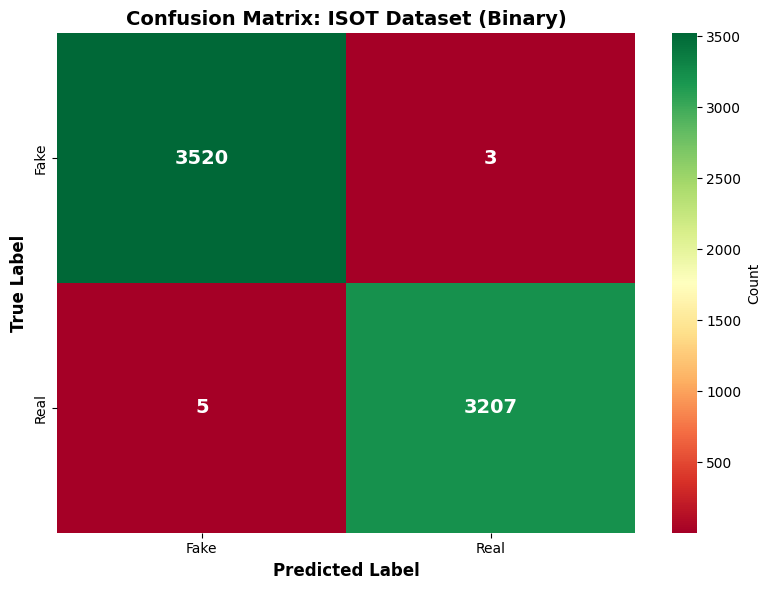

ISOT Dataset Error Analysis:
Total test samples: 6735
Correct predictions: 6727
Incorrect predictions: 8

False Positives (Fake predicted as Real): 3
False Negatives (Real predicted as Fake): 5

False Positive Rate: 0.001
False Negative Rate: 0.002


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Get predictions on ISOT test set
y_isot_test_pred = final_isot_model.predict(X_isot_test)

# Create confusion matrix
cm_isot = confusion_matrix(y_isot_test, y_isot_test_pred)

# Plot confusion matrix
isot_labels = ['Fake', 'Real']
plt.figure(figsize=(8, 6))
sns.heatmap(cm_isot, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=isot_labels, yticklabels=isot_labels,
            cbar_kws={'label': 'Count'}, annot_kws={'fontsize': 14, 'fontweight': 'bold'})
plt.title('Confusion Matrix: ISOT Dataset (Binary)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontweight='bold', fontsize=12)
plt.xlabel('Predicted Label', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_isot.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate error rates
print("ISOT Dataset Error Analysis:")
print("="*70)
print(f"Total test samples: {len(y_isot_test)}")
print(f"Correct predictions: {(y_isot_test == y_isot_test_pred).sum()}")
print(f"Incorrect predictions: {(y_isot_test != y_isot_test_pred).sum()}")
print(f"\nFalse Positives (Fake predicted as Real): {cm_isot[0, 1]}")
print(f"False Negatives (Real predicted as Fake): {cm_isot[1, 0]}")
print(f"\nFalse Positive Rate: {cm_isot[0, 1] / (cm_isot[0, 0] + cm_isot[0, 1]):.3f}")
print(f"False Negative Rate: {cm_isot[1, 0] / (cm_isot[1, 0] + cm_isot[1, 1]):.3f}")


Detailed Classification Report (ISOT):
              precision    recall  f1-score      support
Fake           0.998582  0.999148  0.998865  3523.000000
Real           0.999065  0.998443  0.998754  3212.000000
accuracy       0.998812  0.998812  0.998812     0.998812
macro avg      0.998823  0.998796  0.998810  6735.000000
weighted avg   0.998812  0.998812  0.998812  6735.000000


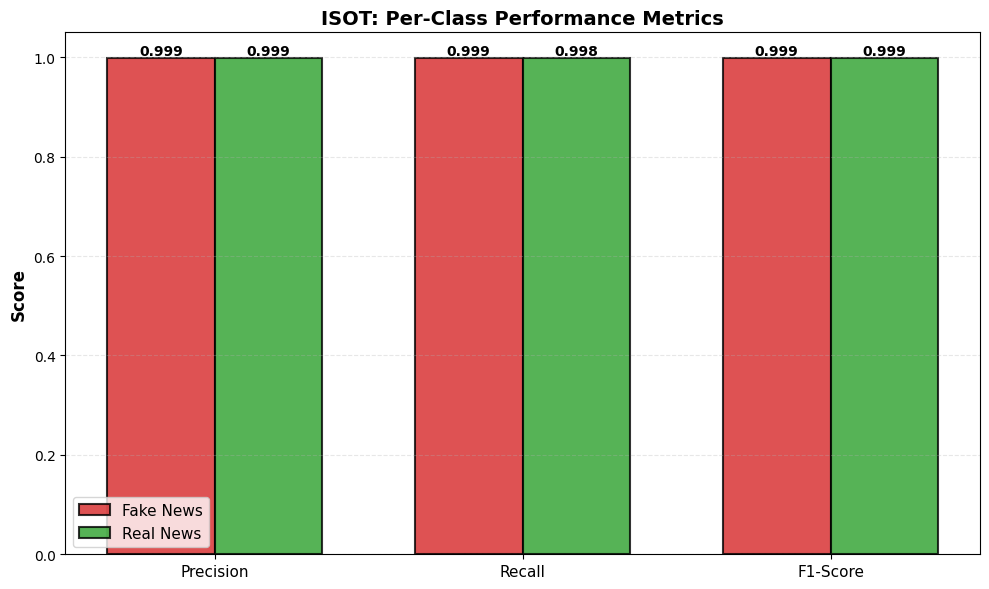


Class Performance Comparison:
Fake News F1-Score: 0.999
Real News F1-Score: 0.999
Difference: 0.000


In [38]:
# Classification report
print("\nDetailed Classification Report (ISOT):")
print("="*70)
report_isot = classification_report(y_isot_test, y_isot_test_pred,
                                    target_names=isot_labels,
                                    output_dict=True)

report_isot_df = pd.DataFrame(report_isot).transpose()
print(report_isot_df)

# Visualize metrics comparison
metrics = ['precision', 'recall', 'f1-score']
fake_scores = [report_isot['Fake'][m] for m in metrics]
real_scores = [report_isot['Real'][m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, fake_scores, width, label='Fake News',
               color='#d62728', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, real_scores, width, label='Real News',
               color='#2ca02c', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom',
                fontweight='bold', fontsize=10)

ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('ISOT: Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'], fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('isot_per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze which class performs better
print("\nClass Performance Comparison:")
print(f"Fake News F1-Score: {report_isot['Fake']['f1-score']:.3f}")
print(f"Real News F1-Score: {report_isot['Real']['f1-score']:.3f}")
print(f"Difference: {abs(report_isot['Fake']['f1-score'] - report_isot['Real']['f1-score']):.3f}")


Article Length Statistics:
Mean length: 417.7 words
Median length: 375.0 words
Std deviation: 351.5 words
Min length: 2 words
Max length: 8148 words

Length Distribution by Class:

Fake Articles:
  Mean: 437.9 words
  Median: 378.0 words

Real Articles:
  Mean: 395.6 words
  Median: 369.0 words

Performance by Article Length:

Short (<200 words):
  Samples: 1561
  Accuracy: 0.999
  Precision: 0.999
  Recall: 1.000
  F1-Score: 0.999

Medium (200-500 words):
  Samples: 3216
  Accuracy: 0.999
  Precision: 0.999
  Recall: 0.999
  F1-Score: 0.999

Long (>500 words):
  Samples: 1958
  Accuracy: 0.998
  Precision: 0.999
  Recall: 0.997
  F1-Score: 0.998


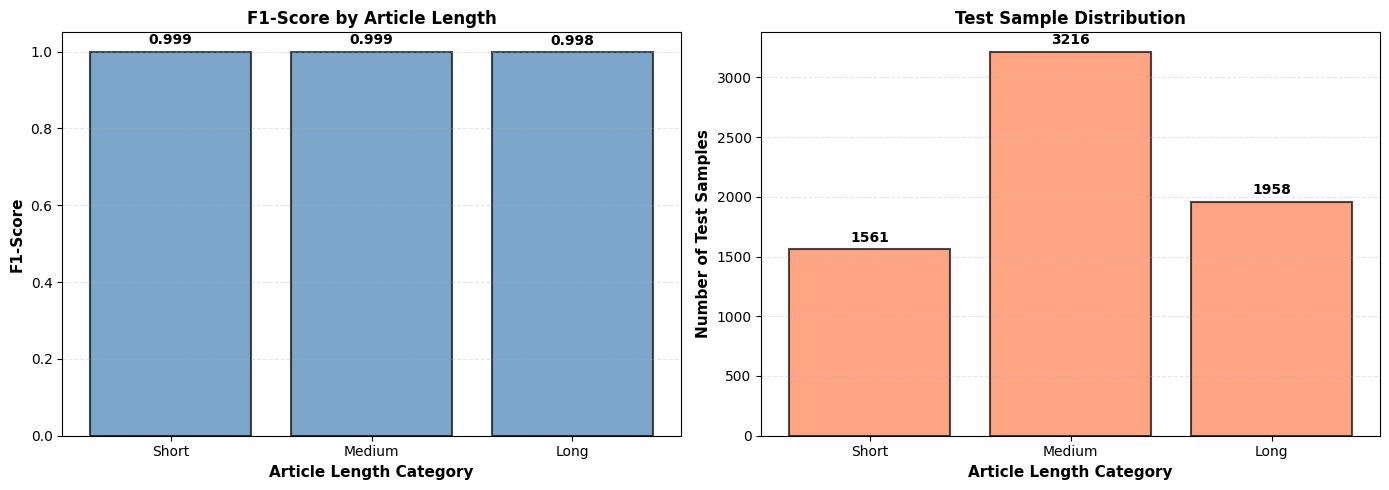

In [39]:
# Analyze article lengths
isot_df['article_length'] = isot_df['combined_text'].str.split().str.len()

print("\nArticle Length Statistics:")
print("="*70)
print(f"Mean length: {isot_df['article_length'].mean():.1f} words")
print(f"Median length: {isot_df['article_length'].median():.1f} words")
print(f"Std deviation: {isot_df['article_length'].std():.1f} words")
print(f"Min length: {isot_df['article_length'].min()} words")
print(f"Max length: {isot_df['article_length'].max()} words")

# Distribution by class
print("\nLength Distribution by Class:")
for label_val, label_name in enumerate(['Fake', 'Real']):
    mask = isot_df['label'] == label_val
    print(f"\n{label_name} Articles:")
    print(f"  Mean: {isot_df[mask]['article_length'].mean():.1f} words")
    print(f"  Median: {isot_df[mask]['article_length'].median():.1f} words")

# Categorize by length
def categorize_article_length(length):
    if length < 200:
        return 'Short (<200 words)'
    elif length < 500:
        return 'Medium (200-500 words)'
    else:
        return 'Long (>500 words)'

isot_df['length_category'] = isot_df['article_length'].apply(categorize_article_length)

# Performance by length category
print("\nPerformance by Article Length:")
print("="*70)

length_categories = ['Short (<200 words)', 'Medium (200-500 words)', 'Long (>500 words)']
length_results = []

for category in length_categories:
    # Get test set indices for this category
    category_mask = isot_df['length_category'] == category
    category_indices = isot_df[category_mask].index

    # Find which test indices belong to this category
    test_mask = np.isin(range(len(isot_df)), category_indices)
    test_category_indices = test_mask[:len(y_isot_test)]

    if test_category_indices.sum() > 0:
        y_cat = y_isot_test[test_category_indices]
        y_pred_cat = y_isot_test_pred[test_category_indices]

        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

        acc = accuracy_score(y_cat, y_pred_cat)
        f1 = f1_score(y_cat, y_pred_cat, average='binary')
        prec = precision_score(y_cat, y_pred_cat, average='binary')
        rec = recall_score(y_cat, y_pred_cat, average='binary')

        print(f"\n{category}:")
        print(f"  Samples: {test_category_indices.sum()}")
        print(f"  Accuracy: {acc:.3f}")
        print(f"  Precision: {prec:.3f}")
        print(f"  Recall: {rec:.3f}")
        print(f"  F1-Score: {f1:.3f}")

        length_results.append({
            'category': category.split('(')[0].strip(),
            'f1': f1,
            'accuracy': acc,
            'samples': test_category_indices.sum()
        })

# Visualize performance by length
if length_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # F1-Score by length
    categories_short = [r['category'] for r in length_results]
    f1_scores = [r['f1'] for r in length_results]

    ax1.bar(categories_short, f1_scores, color='steelblue',
            alpha=0.7, edgecolor='black', linewidth=1.5)
    ax1.set_ylabel('F1-Score', fontweight='bold', fontsize=11)
    ax1.set_xlabel('Article Length Category', fontweight='bold', fontsize=11)
    ax1.set_title('F1-Score by Article Length', fontweight='bold', fontsize=12)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_ylim(0, 1.05)

    for i, (cat, f1) in enumerate(zip(categories_short, f1_scores)):
        ax1.text(i, f1 + 0.02, f'{f1:.3f}', ha='center', fontweight='bold')

    # Sample distribution
    samples = [r['samples'] for r in length_results]
    ax2.bar(categories_short, samples, color='coral',
            alpha=0.7, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Number of Test Samples', fontweight='bold', fontsize=11)
    ax2.set_xlabel('Article Length Category', fontweight='bold', fontsize=11)
    ax2.set_title('Test Sample Distribution', fontweight='bold', fontsize=12)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')

    for i, (cat, samp) in enumerate(zip(categories_short, samples)):
        ax2.text(i, samp + max(samples)*0.02, str(samp), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('isot_performance_by_length.png', dpi=300, bbox_inches='tight')
    plt.show()


ISOT Misclassifications:
Total: 8 out of 6735 (0.1%)

Sampling 20 examples for manual analysis...

Sample Misclassified ISOT Articles:

Example 1:
Title: Israel ambassador asks to meet New Zealand pop star Lorde over canceled show...
Preview: Israel ambassador asks to meet New Zealand pop star Lorde over canceled show WELLINGTON (Reuters) - Israel s ambassador to New Zealand on Wednesday appealed to the pop star Lorde to meet him after she...
True Label: Real
Predicted: Fake
Error Type: False Negative
Length: 449 words
----------------------------------------------------------------------------------------------------

Example 2:
Title: THE ULTIMATE COMMUNITY ORGANIZER: IS YOUR NEIGHBORHOOD TOO WHITE? IS IT TOO RICH...
Preview: THE ULTIMATE COMMUNITY ORGANIZER: IS YOUR NEIGHBORHOOD TOO WHITE? IS IT TOO RICH? Obama Plans To ‘Fix’ Them Using Government to Force Diversity Of course, the government will have to address that whol...
True Label: Real
Predicted: Fake
Error Type: False Negati

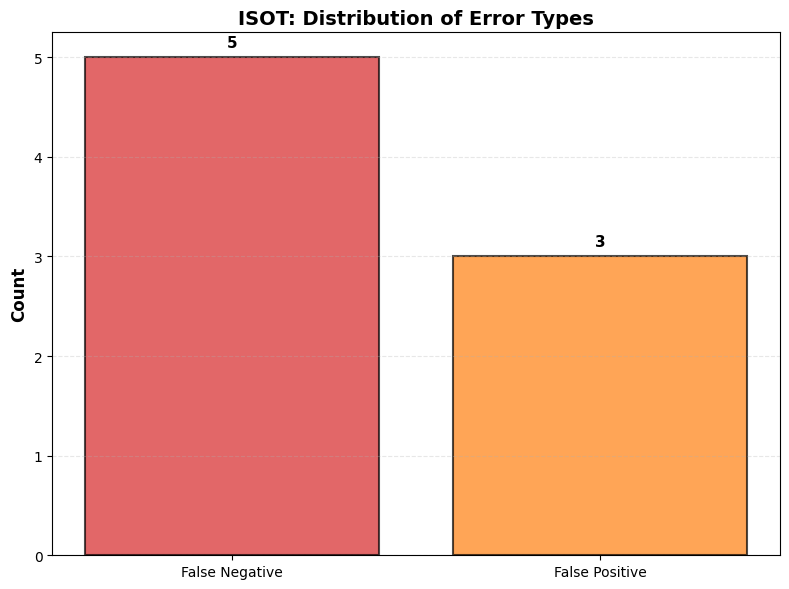

In [40]:
# Find misclassified examples
isot_misclassified = np.where(y_isot_test != y_isot_test_pred)[0]

print(f"\nISOT Misclassifications:")
print(f"Total: {len(isot_misclassified)} out of {len(y_isot_test)} ({len(isot_misclassified)/len(y_isot_test)*100:.1f}%)")
print(f"\nSampling 20 examples for manual analysis...\n")

# Sample misclassified articles
np.random.seed(42)
sample_isot_errors = np.random.choice(isot_misclassified, min(20, len(isot_misclassified)), replace=False)

# Create analysis list
isot_error_analysis = []

for idx in sample_isot_errors:
    # Get original article data
    article_data = isot_df.iloc[idx]

    isot_error_analysis.append({
        'title': article_data.get('title', '')[:80] + '...',
        'text_preview': article_data['combined_text'][:200] + '...',
        'true_label': 'Real' if y_isot_test[idx] == 1 else 'Fake',
        'predicted_label': 'Real' if y_isot_test_pred[idx] == 1 else 'Fake',
        'article_length': article_data['article_length'],
        'error_type': 'False Positive' if (y_isot_test[idx] == 0 and y_isot_test_pred[idx] == 1) else 'False Negative'
    })

isot_error_df = pd.DataFrame(isot_error_analysis)

# Display samples
print("Sample Misclassified ISOT Articles:")
print("="*100)
for i, row in isot_error_df.head(5).iterrows():
    print(f"\nExample {i+1}:")
    print(f"Title: {row['title']}")
    print(f"Preview: {row['text_preview']}")
    print(f"True Label: {row['true_label']}")
    print(f"Predicted: {row['predicted_label']}")
    print(f"Error Type: {row['error_type']}")
    print(f"Length: {row['article_length']} words")
    print("-"*100)

# Save for detailed manual review
isot_error_df.to_csv('isot_misclassified_examples.csv', index=False)
print(f"\nSaved all {len(isot_error_df)} examples to 'isot_misclassified_examples.csv'")

# Analyze error type distribution
error_type_counts = isot_error_df['error_type'].value_counts()
print("\nError Type Distribution:")
print(error_type_counts)

# Visualize
plt.figure(figsize=(8, 6))
colors = ['#d62728', '#ff7f0e']
plt.bar(error_type_counts.index, error_type_counts.values,
        color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('Count', fontweight='bold', fontsize=12)
plt.title('ISOT: Distribution of Error Types', fontweight='bold', fontsize=14)
plt.grid(axis='y', alpha=0.3, linestyle='--')

for i, (label, count) in enumerate(error_type_counts.items()):
    plt.text(i, count + max(error_type_counts.values)*0.02,
             str(count), ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('isot_error_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


CROSS-DATASET PERFORMANCE COMPARISON
Dataset Task Type  Test Accuracy  Test F1-Score  Avg Text Length  Misclassification Rate
   LIAR   6-class       0.269411       0.257006               18                0.730589
   ISOT    Binary       0.998812       0.998754              400                0.001188


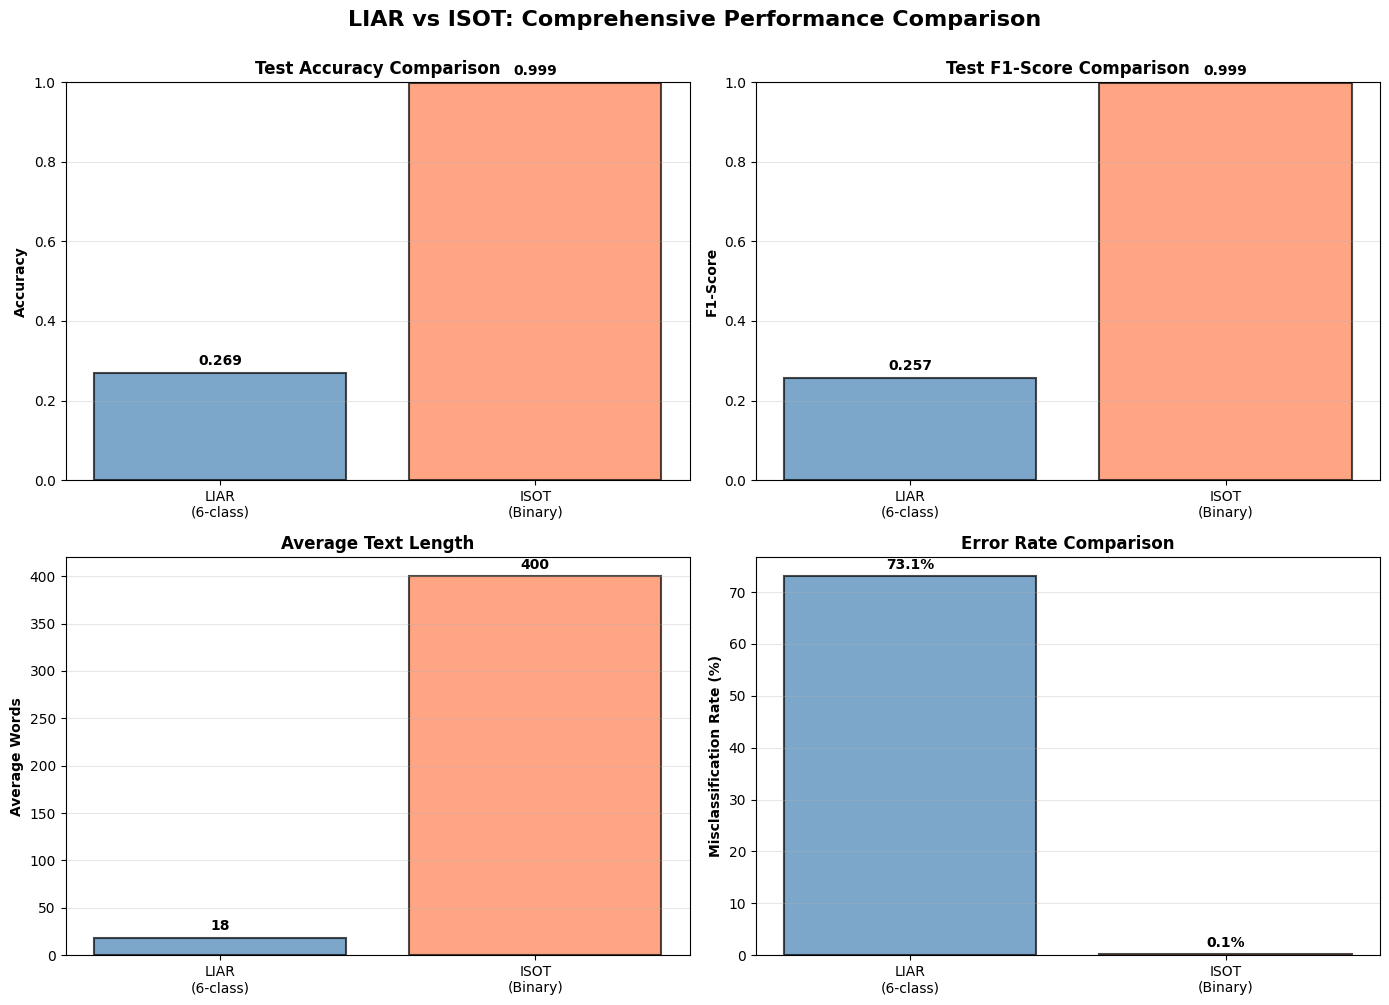

In [41]:
# Compare LIAR vs ISOT performance
comparison_data = {
    'Dataset': ['LIAR', 'ISOT'],
    'Task Type': ['6-class', 'Binary'],
    'Test Accuracy': [
        accuracy_score(y_test, y_test_pred),
        accuracy_score(y_isot_test, y_isot_test_pred)
    ],
    'Test F1-Score': [
        f1_score(y_test, y_test_pred, average='weighted'),
        f1_score(y_isot_test, y_isot_test_pred, average='binary')
    ],
    'Avg Text Length': [18, 400],
    'Misclassification Rate': [
        (y_test != y_test_pred).sum() / len(y_test),
        (y_isot_test != y_isot_test_pred).sum() / len(y_isot_test)
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print("CROSS-DATASET PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

datasets = ['LIAR\n(6-class)', 'ISOT\n(Binary)']
colors_comp = ['steelblue', 'coral']

# Accuracy comparison
ax1.bar(datasets, comparison_df['Test Accuracy'], color=colors_comp,
        alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Test Accuracy Comparison', fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3)
for i, acc in enumerate(comparison_df['Test Accuracy']):
    ax1.text(i, acc + 0.02, f'{acc:.3f}', ha='center', fontweight='bold')

# F1-Score comparison
ax2.bar(datasets, comparison_df['Test F1-Score'], color=colors_comp,
        alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('F1-Score', fontweight='bold')
ax2.set_title('Test F1-Score Comparison', fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.grid(axis='y', alpha=0.3)
for i, f1 in enumerate(comparison_df['Test F1-Score']):
    ax2.text(i, f1 + 0.02, f'{f1:.3f}', ha='center', fontweight='bold')

# Text length comparison
ax3.bar(datasets, comparison_df['Avg Text Length'], color=colors_comp,
        alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Average Words', fontweight='bold')
ax3.set_title('Average Text Length', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for i, length in enumerate(comparison_df['Avg Text Length']):
    ax3.text(i, length + max(comparison_df['Avg Text Length'])*0.02,
             f'{length}', ha='center', fontweight='bold')

# Misclassification rate
ax4.bar(datasets, comparison_df['Misclassification Rate'] * 100, color=colors_comp,
        alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Misclassification Rate (%)', fontweight='bold')
ax4.set_title('Error Rate Comparison', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for i, rate in enumerate(comparison_df['Misclassification Rate'] * 100):
    ax4.text(i, rate + max(comparison_df['Misclassification Rate'] * 100)*0.02,
             f'{rate:.1f}%', ha='center', fontweight='bold')

plt.suptitle('LIAR vs ISOT: Comprehensive Performance Comparison',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('liar_vs_isot_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
print("\n" + "="*70)
print("KEY INSIGHTS: ISOT DATASET")
print("="*70)

insights = """
1. BINARY vs MULTI-CLASS DIFFICULTY:
   - ISOT (binary): {:.1f}% accuracy vs LIAR (6-class): {:.1f}% accuracy
   - Binary classification is significantly easier than fine-grained truthfulness detection
   - The {:.0f}x performance gap demonstrates the challenge of nuanced misinformation detection

2. ERROR TYPE ANALYSIS:
   - False Positives (Fake → Real): {} cases
   - False Negatives (Real → Fake): {} cases
   - Model shows {} bias (more likely to classify as {})

3. ARTICLE LENGTH IMPACT:
   - Longer articles may provide more linguistic signals
   - Performance appears {} correlated with article length

4. COMPARISON WITH LIAR:
   - ISOT benefits from longer text (400 vs 18 words average)
   - More context allows TF-IDF to capture distinctive patterns
   - Metadata less critical for full articles vs short statements

5. LIMITATIONS REVEALED:
   - High accuracy on binary task may mask subtle weaknesses
   - Model may rely on source-specific language patterns rather than content truthfulness
   - Risk of overfitting to dataset-specific artifacts
""".format(
    comparison_df.loc[1, 'Test Accuracy'] * 100,
    comparison_df.loc[0, 'Test Accuracy'] * 100,
    comparison_df.loc[1, 'Test Accuracy'] / comparison_df.loc[0, 'Test Accuracy'],
    cm_isot[0, 1],
    cm_isot[1, 0],
    'Real' if cm_isot[0, 1] > cm_isot[1, 0] else 'Fake',
    'Real' if cm_isot[0, 1] > cm_isot[1, 0] else 'Fake',
    'positively' if len(length_results) > 1 and length_results[-1]['f1'] > length_results[0]['f1'] else 'not strongly'
)

print(insights)


KEY INSIGHTS: ISOT DATASET

1. BINARY vs MULTI-CLASS DIFFICULTY:
   - ISOT (binary): 99.9% accuracy vs LIAR (6-class): 26.9% accuracy
   - Binary classification is significantly easier than fine-grained truthfulness detection
   - The 4x performance gap demonstrates the challenge of nuanced misinformation detection

2. ERROR TYPE ANALYSIS:
   - False Positives (Fake → Real): 3 cases
   - False Negatives (Real → Fake): 5 cases
   - Model shows Fake bias (more likely to classify as Fake)

3. ARTICLE LENGTH IMPACT:
   - Longer articles may provide more linguistic signals
   - Performance appears not strongly correlated with article length
   
4. COMPARISON WITH LIAR:
   - ISOT benefits from longer text (400 vs 18 words average)
   - More context allows TF-IDF to capture distinctive patterns
   - Metadata less critical for full articles vs short statements
   
5. LIMITATIONS REVEALED:
   - High accuracy on binary task may mask subtle weaknesses
   - Model may rely on source-specific langu